In [3]:
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt

# download csv from https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv
data = pd.read_csv('data/130001_tokyo_covid19_patients.csv', parse_dates=['公表_年月日', '発症_年月日', '確定_年月日'], low_memory=False)

# import io

# import requests
# from cachecontrol import CacheControl 
# from cachecontrol.caches import FileCache

# cached_session = CacheControl(requests.Session(), cache=FileCache('.webcache'))
# response = cached_session.get('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv') 
# data = pd.read_csv(io.StringIO(response.text), parse_dates = ['公表_年月日', '発症_年月日', '確定_年月日'], low_memory=False)

data[-1:]

,No,全国地方公共団体コード,都道府県名,市区町村名,公表_年月日,発症_年月日,確定_年月日,患者_居住地,患者_年代,患者_性別,患者_職業,患者_状態,患者_症状,患者_渡航歴の有無フラグ,患者_接触歴の有無フラグ,備考,退院済フラグ
332087,331204,130001,東京都,NaN,2021-08-27,NaT,NaT,NaN,50代,男性,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data = data[(data['公表_年月日'] >= date(date.today().year - 1, date.today().month, date.today().day).strftime('%Y-%m-%d')) & (data['公表_年月日'] < date.today().strftime('%Y-%m-%d'))]

daily = data.groupby("公表_年月日").size().to_frame('count')

In [5]:
daily['7dmean'] = daily.rolling(window='7D').mean()

# ref. COVID-19感染報告者数に基づく簡易実効再生産数推定方法
# https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/2502-idsc/iasr-in/10465-496d04.html
def calc_ern(*args, **kwargs):
    return sum(args[0][-7:]) / sum(args[0][:7])

daily['ern'] = daily['count'].rolling(window='19D').apply(calc_ern)
daily['ernmean'] = daily['ern'].rolling(window='5D').mean()

def calc_ern_old(*args, **kwargs):
    return (sum(args[0][-7:]) / sum(args[0][:7])) ** (5/7)

daily['ern_old'] = daily['count'].rolling(window='19D').apply(calc_ern_old)


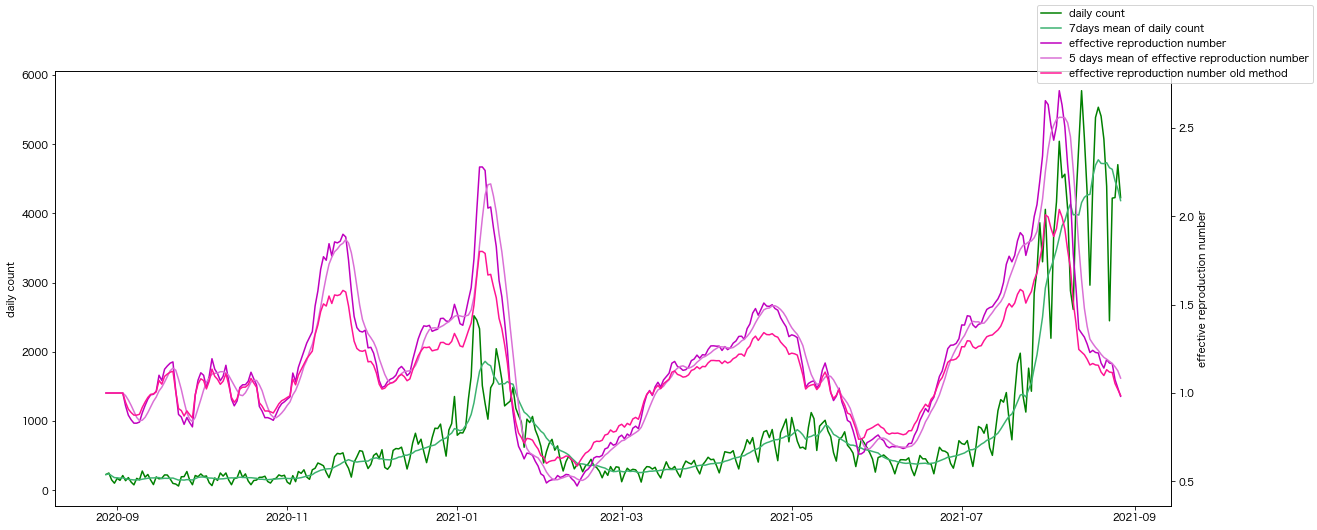

In [6]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.subplots()
ax2 = ax1.twinx()

ax1.plot(daily['count'], color='g', label='daily count')
ax1.plot(daily['7dmean'], color='mediumseagreen', label='7days mean of daily count')

ax1.set_ylabel('daily count')

ax2.plot(daily['ern'], color='m', label='effective reproduction number')
ax2.plot(daily['ernmean'], color='orchid', label='5 days mean of effective reproduction number')
ax2.plot(daily['ern_old'], color='deeppink', label='effective reproduction number old method')
ax2.set_ylabel('effective reproduction number')

fig.legend()
